# Analyze and visualize last.fm listening history

To see this analysis live, check out my article ["Analyzing Last.fm Listening History"](http://geoffboeing.com/2016/05/analyzing-lastfm-history/)

The csv data files were created with [lastfm_downloader.ipynb](lastfm_downloader.ipynb)

In [1]:
import pandas as pd, numpy as np, string, re, pytz
import matplotlib.pyplot as plt, matplotlib.font_manager as fm
from datetime import datetime as dt
%matplotlib inline

In [10]:
# define the fonts to use for plots
family = 'DejaVu Sans'
title_font = fm.FontProperties(family=family, style='normal', size=20, weight='normal', stretch='normal')
label_font = fm.FontProperties(family=family, style='normal', size=16, weight='normal', stretch='normal')
ticks_font = fm.FontProperties(family=family, style='normal', size=12, weight='normal', stretch='normal')
ticks_font_h = fm.FontProperties(family=family, style='normal', size=10.5, weight='normal', stretch='normal')

In [11]:
def get_colors(cmap, n, start=0., stop=1., alpha=1., reverse=False):
    '''return n-length list of rgba colors from the passed colormap name and alpha,
       limit extent by start/stop values and reverse list order if flag is true'''
    import matplotlib.cm as cm, numpy as np
    colors = [cm.get_cmap(cmap)(x) for x in np.linspace(start, stop, n)]
    colors = [(r, g, b, alpha) for r, g, b, _ in colors]
    return list(reversed(colors)) if reverse else colors

## Top artists

In [12]:
artists_most = pd.read_csv('data/lastfm_top_artists.csv', encoding='utf-8')
artists_most = artists_most.set_index('artist')['play_count'].head(25)
artists_most.head()

artist
The White Stripes    1196
The Dead Weather      811
Portishead            800
The Black Keys        695
Kasabian              678
Name: play_count, dtype: int64

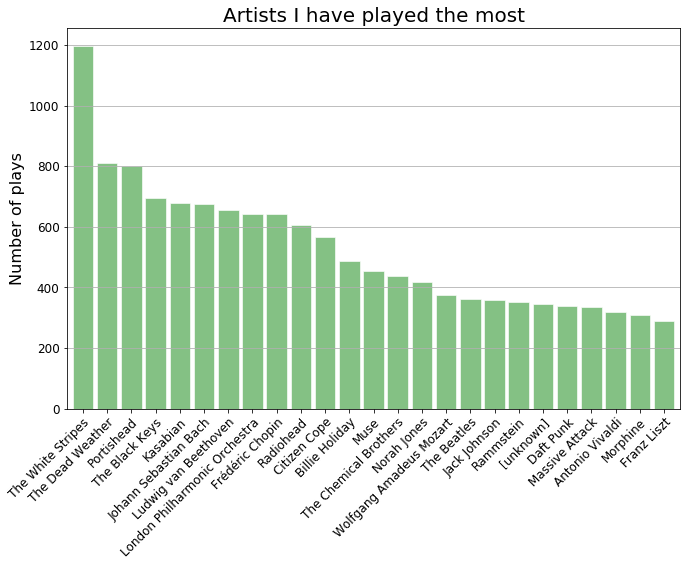

In [13]:
ax = artists_most.plot(kind='bar', figsize=[11, 7], width=0.85, alpha=0.6, color='#339933', edgecolor='w')

ax.yaxis.grid(True)
ax.set_xticklabels(artists_most.index, rotation=45, rotation_mode='anchor', ha='right', fontproperties=ticks_font)
for label in ax.get_yticklabels():
    label.set_fontproperties(ticks_font)

ax.set_title('Artists I have played the most', fontproperties=title_font)
ax.set_xlabel('', fontproperties=label_font)
ax.set_ylabel('Number of plays', fontproperties=label_font)

plt.savefig('images/lastfm-artists-played-most.png', dpi=96, bbox_inches='tight')
plt.show()

## Top tracks

In [14]:
tracks_most = pd.read_csv('data/lastfm_top_tracks.csv', encoding='utf-8')
index = tracks_most.apply(lambda x: '{}\n{}'.format(x['artist'], x['track']), axis='columns')
tracks_most = tracks_most.set_index(index).drop(labels=['artist', 'track'], axis='columns')
tracks_most = tracks_most['play_count'].head(20)
tracks_most.head()

Ludwig van Beethoven\nSymphony No.7 in A, Op.92: 2. Allegretto                     178
Radiohead\nWeird Fishes/ Arpeggi                                                   136
The Killers\nRead My Mind                                                          106
London Philharmonic Orchestra\nOrchestral Suite No. 3 in D major, BWV 1068: Air     97
Muzio Clementi\nKeyboard Sonatina In C Major, Op. 36, No. 1: I. Allegro             95
Name: play_count, dtype: int64

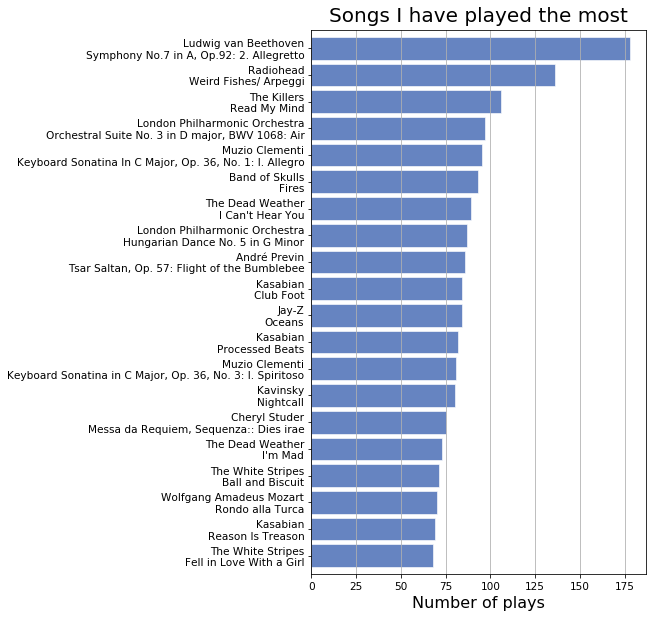

In [15]:
ax = tracks_most.sort_values().plot(kind='barh', figsize=[6, 10], width=0.85, alpha=0.6, color='#003399', edgecolor='w')
ax.xaxis.grid(True)
for label in ax.get_xticklabels():
    label.set_fontproperties(ticks_font_h)
for label in ax.get_yticklabels():
    label.set_fontproperties(ticks_font_h)
ax.set_xlabel('Number of plays', fontproperties=label_font)
ax.set_ylabel('', fontproperties=label_font)
ax.set_title('Songs I have played the most', fontproperties=title_font, y=1.005)

plt.savefig('images/lastfm-tracks-played-most-h.png', dpi=96, bbox_inches='tight')
plt.show()

## Top albums

In [16]:
albums_most = pd.read_csv('data/lastfm_top_albums.csv', encoding='utf-8')
index = albums_most.apply(lambda x: '{}\n{}'.format(x['artist'], x['album']), axis='columns')
albums_most = albums_most.set_index(index).drop(labels=['artist', 'album'], axis='columns')
albums_most = albums_most['play_count'].head(30)
albums_most.head()

Kasabian\nKasabian                                                          536
The Dead Weather\nSea of Cowards                                            461
The White Stripes\nWhite Blood Cells                                        397
London Philharmonic Orchestra\nThe 50 Greatest Pieces of Classical Music    380
Norah Jones\nCome Away with Me                                              302
Name: play_count, dtype: int64

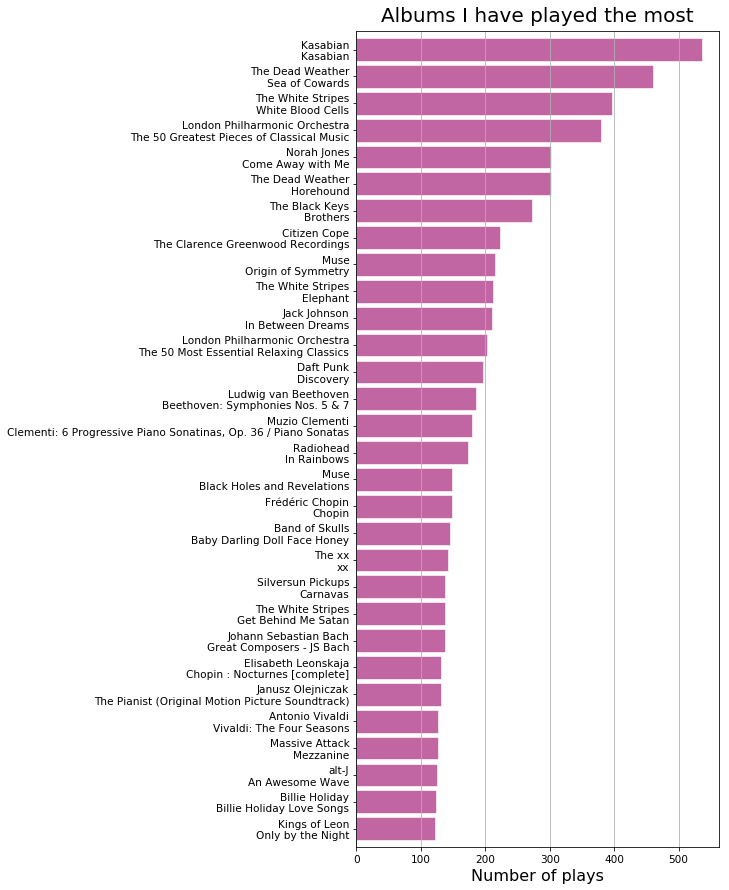

In [17]:
ax = albums_most.sort_values().plot(kind='barh', figsize=[6.5, 15], width=0.85, alpha=0.6, color='#990066', edgecolor='w')
ax.xaxis.grid(True)
for label in ax.get_xticklabels():
    label.set_fontproperties(ticks_font_h)
for label in ax.get_yticklabels():
    label.set_fontproperties(ticks_font_h)
ax.set_xlabel('Number of plays', fontproperties=label_font)
ax.set_ylabel('', fontproperties=label_font)
ax.set_title('Albums I have played the most', fontproperties=title_font, y=1.005)

plt.savefig('images/lastfm-albums-played-most-h.png', dpi=96, bbox_inches='tight')
plt.show()

## All-time scrobbles

In [18]:
# read the all-time scrobbles data set
scrobbles = pd.read_csv('data/lastfm_scrobbles.csv', encoding='utf-8')
scrobbles = scrobbles.drop('timestamp', axis=1)
print('{:,} total scrobbles'.format(len(scrobbles)))
print('{:,} total artists'.format(len(scrobbles['artist'].unique())))

42,807 total scrobbles
3,013 total artists


According to the last.fm web site, I have ~282,000 scrobbles. This API endpoint seems to miss the ones from before 2007.

In [19]:
# convert to datetime
scrobbles['timestamp'] = pd.to_datetime(scrobbles['datetime'])

In [20]:
# functions to convert UTC to Pacific time zone and extract date/time elements
convert_tz = lambda x: x.to_pydatetime().replace(tzinfo=pytz.utc).astimezone(pytz.timezone('US/Pacific'))
get_year = lambda x: convert_tz(x).year
get_month = lambda x: '{}-{:02}'.format(convert_tz(x).year, convert_tz(x).month) #inefficient
get_day = lambda x: convert_tz(x).day
get_hour = lambda x: convert_tz(x).hour
get_day_of_week = lambda x: convert_tz(x).weekday()

These lambda functions are inefficient, but necessary to workaround this bug: https://github.com/pydata/pandas/issues/11757. I can update them when the bug is fixed in a future pandas version.

In [21]:
# parse out date and time elements as pacific time
scrobbles['year'] = scrobbles['timestamp'].map(get_year)
scrobbles['month'] = scrobbles['timestamp'].map(get_month)
scrobbles['day'] = scrobbles['timestamp'].map(get_day)
scrobbles['hour'] = scrobbles['timestamp'].map(get_hour)
scrobbles['dow'] = scrobbles['timestamp'].map(get_day_of_week)
scrobbles = scrobbles.drop(labels=['datetime'], axis=1)

# drop rows with 01-01-1970 as timestamp
scrobbles = scrobbles[scrobbles['year'] > 1970]
scrobbles.head()

,artist,artist_mbid,album,album_mbid,track,track_mbid,timestamp,year,month,day,hour,dow
0,Anne Akiko Meyers,91cffe48-b682-4e2a-ad90-b09633f4a8f7,Smile,NaN,Arvo Part: Spiegel Im Spiegel (mirror In Mirror),NaN,2017-02-01 15:21:39,2017,2017-02,1,7,2
1,Camille Saint-Saëns,4137c070-15b2-4d00-a9f0-3517d02a9ba8,100 Classical Favourites,NaN,Le carnaval des animaux: Le cygne,NaN,2017-02-01 15:18:28,2017,2017-02,1,7,2
2,Ludwig van Beethoven,1f9df192-a621-4f54-8850-2c5373b7eac9,The King's Speech OST,NaN,Speaking Unto Nations (Beethoven Symphony no 7...,NaN,2017-02-01 15:13:27,2017,2017-02,1,7,2
3,Remo Giazotto,d6f85c05-93a6-4c1a-bcd9-84d712bf0cff,Albinoni / Barber / Handel (Uk),NaN,Adagio in G Minor (attrib. to Albinoni),3350db72-5a90-4324-9a61-15b7f02391f7,2017-02-01 15:01:54,2017,2017-02,1,7,2
4,Tomaso Giovanni Albinoni,83903121-f611-4875-984c-673ae7173e56,Great Baroque Favorites: Pachelbel's Canon,NaN,Adagio in G minor,2809df55-d82f-4528-b2ec-7f9fa3f23794,2017-02-01 14:53:32,2017,2017-02,1,6,2


All the last.fm timestamps of my scrobbles appear to be UTC, but the year, month, day, hour columns are now converted to Pacific Time (where I've done nearly all my listening)

## Year-by-year analysis

Visualize the number of scrobbles per year

TypeError: unorderable types: str() > float()

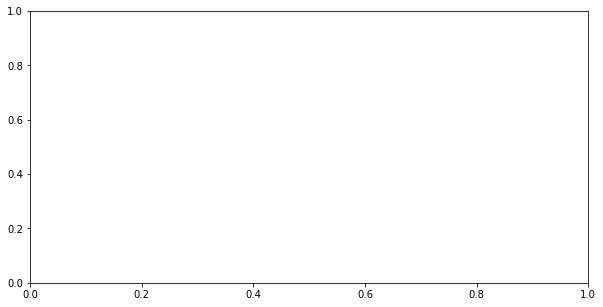

In [22]:
year_counts = scrobbles['year'].value_counts().sort_index()
ax = year_counts.plot(kind='line', figsize=[10, 5], linewidth='4', alpha=0.6, marker='o', color='#003399')

ax.yaxis.grid(True)
ax.set_xticklabels(year_counts.index, rotation=0, rotation_mode='anchor', ha='center')
ax.set_ylabel('Number of plays', fontproperties=label_font)
ax.set_xlabel('', fontproperties=label_font)
ax.set_title('Number of songs played per year', fontproperties=title_font)

plt.savefig('images/lastfm-scrobbles-per-year.png', dpi=96, bbox_inches='tight')
plt.show()

## Month-by-month analysis

Visualize the number of scrobbles per month from 2010 through the present day

In [23]:
# get all the scrobbles from 2010-present
min_year = 2010
scrobbles_10 = scrobbles[scrobbles['year'] >= min_year]
max_year = max(scrobbles_10['year'])

In [24]:
# count number of scrobbles in each month
month_counts = scrobbles_10['month'].value_counts().sort_index()

# not every month necessarily has a scrobble, so fill in missing months with zero counts
date_range = pd.date_range(start=min(scrobbles_10['timestamp']), end=max(scrobbles_10['timestamp']), freq='D')
months_range = date_range.map(lambda x: str(x.date())[:-3])
index = np.unique(months_range)
month_counts = month_counts.reindex(index, fill_value=0)

TypeError: unorderable types: str() > float()

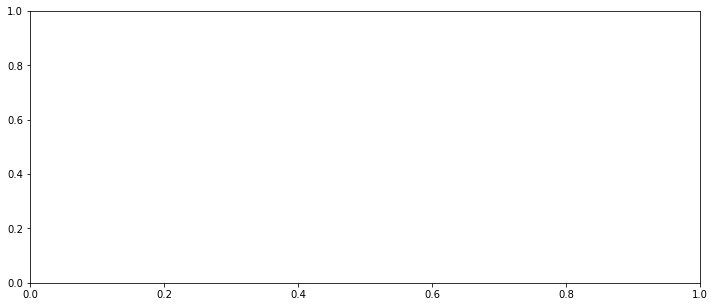

In [25]:
ax = month_counts.plot(kind='line', figsize=[12, 5], linewidth='4', alpha=0.6, marker='.', color='#003399')

xlabels = month_counts.iloc[range(0, len(month_counts), 12)].index
xlabels = [x if x in xlabels else '' for x in month_counts.index]
ax.set_xticks(range(len(xlabels)))
ax.set_xticklabels(xlabels, rotation=40, rotation_mode='anchor', ha='right')

ax.yaxis.grid(True)
ax.set_ylim((0,8000))
ax.set_ylabel('Number of plays', fontproperties=label_font)
ax.set_xlabel('', fontproperties=label_font)
ax.set_title('Number of songs played per month, {}-{}'.format(min_year, max_year), fontproperties=title_font)

plt.savefig('images/lastfm-scrobbles-per-month.png', dpi=96, bbox_inches='tight')
plt.show()

## Day of the week analysis

How many songs have been played on each day of the week?

In [26]:
# get the play count sum by day of the week
dow_counts = scrobbles['dow'].value_counts().sort_index()
dow_counts.index = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

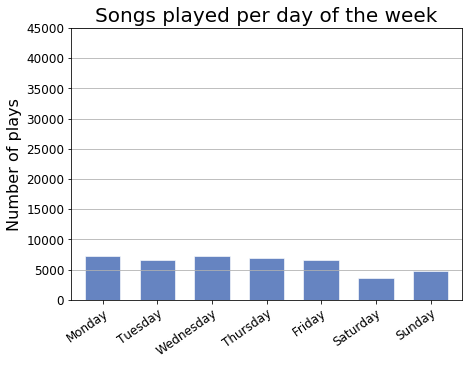

In [27]:
ax = dow_counts.plot(kind='bar', figsize=[7, 5], width=0.65, alpha=0.6, color='#003399', edgecolor='w')

ax.yaxis.grid(True)
ax.set_xticklabels(dow_counts.index, rotation=35, rotation_mode='anchor', ha='right', fontproperties=ticks_font)
for label in ax.get_yticklabels():
    label.set_fontproperties(ticks_font)

ax.set_ylim((0, 45000))
ax.set_title('Songs played per day of the week', fontproperties=title_font)
ax.set_xlabel('', fontproperties=label_font)
ax.set_ylabel('Number of plays', fontproperties=label_font)

plt.savefig('images/lastfm-scrobbles-per-weekday.png', dpi=96, bbox_inches='tight')
plt.show()

## Hour of the day analysis

How many songs have been played during each hour of the day?

TypeError: unorderable types: str() > float()

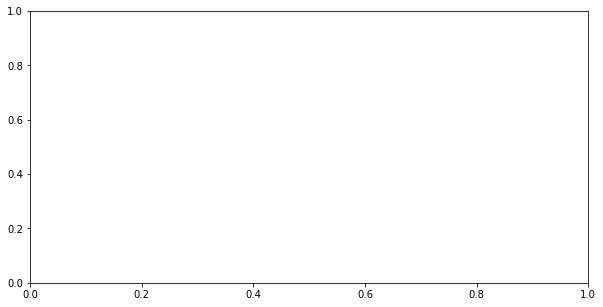

In [28]:
hour_counts = scrobbles['hour'].value_counts().sort_index()
ax = hour_counts.plot(kind='line', figsize=[10, 5], linewidth='4', alpha=0.6, marker='o', color='#003399')

xlabels = hour_counts.index.map(lambda x: '{:02}:00'.format(x))
ax.set_xticks(range(len(xlabels)))
ax.set_xticklabels(xlabels, rotation=45, rotation_mode='anchor', ha='right')

ax.yaxis.grid(True)
ax.set_ylim((0, 18000))
ax.set_ylabel('Number of plays', fontproperties=label_font)
ax.set_xlabel('', fontproperties=label_font)
ax.set_title('Number of songs played per hour of the day', fontproperties=title_font)

plt.savefig('images/lastfm-scrobbles-per-hour.png', dpi=96, bbox_inches='tight')
plt.show()

## Analysis by day of the week + hour of the day

How many songs have been played during each hour of the day on each day of the week?

In [29]:
# get the play counts by hour of day and day of week
weekday_hour_counts = scrobbles.groupby(['dow','hour']).count()['track']
hour_numbers = weekday_hour_counts.index.levels[1]
day_numbers = weekday_hour_counts.index.levels[0]
day_names = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}

/Users/adolfo/bin/anaconda3/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


TypeError: unorderable types: str() > float()

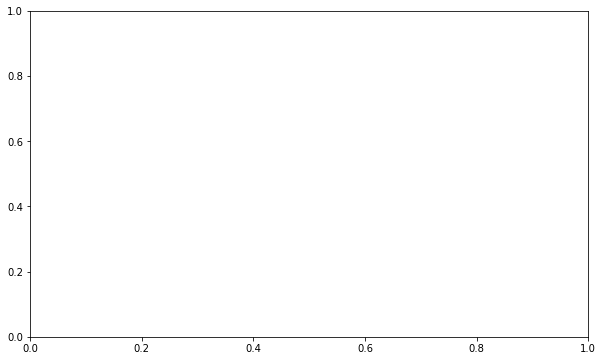

In [30]:
# get one color per day of week
colors = get_colors('spectral', n=len(day_numbers), start=0.05, stop=0.95, reverse=True)

fig, ax = plt.subplots(figsize=[10, 6])
lines = []
for day, c in zip(day_numbers, colors):
    ax = weekday_hour_counts[day].plot(kind='line', linewidth='4', alpha=0.6, marker='.', color=c)
    lines.append(day_names[day])
    
xlabels = hour_numbers.map(lambda x: '{:02}:00'.format(x))
ax.set_xticks(range(len(xlabels)))
ax.set_xticklabels(xlabels, rotation=45, rotation_mode='anchor', ha='right')

ax.yaxis.grid(True)
ax.set_ylabel('Number of plays', fontproperties=label_font)
ax.set_xlabel('', fontproperties=label_font)
ax.set_title('Number of songs played, by day of week and hour of day', fontproperties=title_font)
ax.legend(lines, loc='upper right', bbox_to_anchor=(1.23,1.017))

plt.savefig('images/lastfm-scrobbles-days-hours.png', dpi=96, bbox_inches='tight')
plt.show()

## Analysis of a single year (or multiple years)

Add additional years to the 'isin' list to query multiple years.

In [33]:
scrobbles_year = scrobbles[scrobbles['year'].isin([2016])]
len(scrobbles_year)

3981

In [34]:
# what artists did i play the most that year?
artists_year = scrobbles_year['artist'].value_counts()
artists_year = pd.DataFrame(artists_year).reset_index().rename(columns={'artist':'play count', 'index':'artist'})
artists_year.index = [n + 1 for n in artists_year.index]
artists_year.head(10)

,artist,play count
1,Radiohead,230
2,Antonio Vivaldi,109
3,Frédéric Chopin,103
4,Claude Debussy,88
5,Franz Liszt,84
6,Rammstein,82
7,Giacomo Puccini,79
8,Ludwig van Beethoven,76
9,Franz Schubert,73
10,The Black Keys,63


In [35]:
# what tracks did i play the most that year?
tracks_year = scrobbles_year.groupby(['artist', 'track']).count().sort_values('timestamp', ascending=False)
tracks_year = tracks_year.reset_index().rename(columns={'timestamp':'play count'})[['artist', 'track', 'play count']]
tracks_year.index = [n + 1 for n in tracks_year.index]
tracks_year.head(10)

,artist,track,play count
1,Radiohead,Weird Fishes/ Arpeggi,129
2,Antonio Vivaldi,"Four Seasons op.8 (1987 Digital Remaster), Win...",36
3,Bob Dylan,Girl From the North Country,35
4,Ludwig van Beethoven,"Symphony No.7 in A, Op.92: 2. Allegretto",29
5,Johann Sebastian Bach,"Goldberg Variations, BWV 988: Aria",21
6,Yo-Yo Ma,"Unaccompanied Cello Suite No. 1 In G Major, BW...",19
7,Claude Debussy,Clair de lune,19
8,Giacomo Puccini,La Rondine: Chi il bel sogno di Doretta,16
9,Giacomo Puccini,"Madama Butterfly (1987 - Remaster), Act II: Un...",15
10,Franz Liszt,"Liebestraume, S541/R211 : No. 3: Nocturne in A...",15


In [36]:
# what albums did i play the most that year?
albums_year = scrobbles_year.groupby(['artist', 'album']).count().sort_values('timestamp', ascending=False)
albums_year = albums_year.reset_index().rename(columns={'timestamp':'play count'})[['artist', 'album', 'play count']]
albums_year.index = [n + 1 for n in albums_year.index]

# remove text in parentheses or brackets
regex = re.compile('\\(.*\\)|\\[.*]')
albums_year['album'] = albums_year['album'].map(lambda x: regex.sub('', x))
albums_year.head(10)

,artist,album,play count
1,Radiohead,In Rainbows,148
2,Antonio Vivaldi,Vivaldi: The Four Seasons,62
3,London Philharmonic Orchestra,The 50 Greatest Pieces of Classical Music,50
4,Bob Dylan,Nashville Skyline,35
5,The Black Keys,Brothers,32
6,Radiohead,Amnesiac,29
7,Ludwig van Beethoven,Beethoven: Symphonies Nos. 5 & 7,29
8,Frédéric Chopin,Chopin Masterworks Volume 1,26
9,Franz Liszt,Liszt - My Piano Hero,24
10,Kings of Leon,Only by the Night,23


## Analysis of a single month (or multiple months)

Add additional months to the 'isin' list to query multiple months.

In [41]:
scrobbles_month = scrobbles[scrobbles['month'].isin(['2016-02'])]
len(scrobbles_month)

1

In [42]:
# what artists did i play the most that month?
artists_month = scrobbles_month['artist'].value_counts()
artists_month = pd.DataFrame(artists_month).reset_index().rename(columns={'artist':'play count', 'index':'artist'})
artists_month.index = [n + 1 for n in artists_month.index]
artists_month.head(10)

,artist,play count
1,Czech Symphony Orchestra,1


In [43]:
# what tracks did i play the most that month?
tracks_month = scrobbles_month.groupby(['artist', 'track']).count().sort_values('timestamp', ascending=False)
tracks_month = tracks_month.reset_index().rename(columns={'timestamp':'play count'})[['artist', 'track', 'play count']]
tracks_month.index = [n + 1 for n in tracks_month.index]
tracks_month.head(10)

,artist,track,play count
1,Czech Symphony Orchestra,"I Pagliacci: Act I - ""Vesti La Giubba""",1


In [44]:
# what albums did i play the most that month?
albums_month = scrobbles_month.groupby(['artist', 'album']).count().sort_values('timestamp', ascending=False)
albums_month = albums_month.reset_index().rename(columns={'timestamp':'play count'})[['artist', 'album', 'play count']]
albums_month.index = [n + 1 for n in albums_month.index]
albums_month.head(10)

,artist,album,play count
1,Czech Symphony Orchestra,30 Best Opera Masterpieces,1


## Listening history of a specific artist, album, or track

See the last 5 times I've listened to someone or something

In [48]:
# when were the last 5 times I played something by My Bloody Valentine?
scrobbles[scrobbles['artist'].str.contains('Radiohead')].head()

,artist,artist_mbid,album,album_mbid,track,track_mbid,timestamp,year,month,day,hour,dow
128,Radiohead,a74b1b7f-71a5-4011-9441-d0b5e4122711,In Rainbows,ea92a194-2d60-35c7-9d56-0e1dba20cd45,Weird Fishes/ Arpeggi,NaN,2017-01-31 11:35:29,2017,2017-01,31,3,1
1173,Radiohead,a74b1b7f-71a5-4011-9441-d0b5e4122711,Pablo Honey [COLLECTOR'S EDITION],NaN,Creep,d11fcceb-dfc5-4d19-b45d-f4e8f6d3eaa6,2017-01-15 13:10:16,2017,2017-01,15,5,6
1293,Radiohead,a74b1b7f-71a5-4011-9441-d0b5e4122711,In Rainbows,ea92a194-2d60-35c7-9d56-0e1dba20cd45,Weird Fishes/ Arpeggi,NaN,2017-01-10 06:55:45,2017,2017-01,9,22,0
1541,Radiohead,a74b1b7f-71a5-4011-9441-d0b5e4122711,In Rainbows,ea92a194-2d60-35c7-9d56-0e1dba20cd45,Weird Fishes/ Arpeggi,NaN,2017-01-05 07:49:58,2017,2017-01,4,23,2
1553,Radiohead,a74b1b7f-71a5-4011-9441-d0b5e4122711,In Rainbows,ea92a194-2d60-35c7-9d56-0e1dba20cd45,Weird Fishes/ Arpeggi,NaN,2017-01-04 20:40:34,2017,2017-01,4,12,2


In [49]:
# when were the last 5 times I played something off of Double Nickels on the Dime?
scrobbles[scrobbles['album'].fillna('').str.contains('Double Nickels')].head()

,artist,artist_mbid,album,album_mbid,track,track_mbid,timestamp,year,month,day,hour,dow


In [33]:
# when were the last 5 times I played Personality Crisis?
scrobbles[scrobbles['track'].str.contains('Personality Crisis')].head()

,artist,artist_mbid,album,album_mbid,track,track_mbid,timestamp,year,month,day,hour,dow
6442,New York Dolls,1b96b9c9-0832-40cb-9f8d-7274de3733fc,New York Dolls,1f6cc992-e572-4f3c-b62a-cb6111383e67,Personality Crisis,34a615b2-d58b-4ecf-b4c2-e42df0b9a709,2016-08-26 22:06:40,2016,2016-08,26,15,4
6815,New York Dolls,1b96b9c9-0832-40cb-9f8d-7274de3733fc,Rock 'N Roll,NaN,Personality Crisis,34a615b2-d58b-4ecf-b4c2-e42df0b9a709,2016-08-19 23:54:35,2016,2016-08,19,16,4
16513,New York Dolls,1b96b9c9-0832-40cb-9f8d-7274de3733fc,New York Dolls,1f6cc992-e572-4f3c-b62a-cb6111383e67,Personality Crisis,34a615b2-d58b-4ecf-b4c2-e42df0b9a709,2016-06-26 23:15:40,2016,2016-06,26,16,6
33335,New York Dolls,1b96b9c9-0832-40cb-9f8d-7274de3733fc,New York Dolls,1f6cc992-e572-4f3c-b62a-cb6111383e67,Personality Crisis,34a615b2-d58b-4ecf-b4c2-e42df0b9a709,2016-02-23 02:52:54,2016,2016-02,22,18,0
40201,New York Dolls,1b96b9c9-0832-40cb-9f8d-7274de3733fc,New York Dolls,1f6cc992-e572-4f3c-b62a-cb6111383e67,Personality Crisis,34a615b2-d58b-4ecf-b4c2-e42df0b9a709,2015-12-12 04:30:46,2015,2015-12,11,20,4


## Visualize top artists over time

How have the cumulative plays of most listened-to artists changed over time?

In [50]:
# get the cumulative play counts since 2009 for the top n most listened-to artists
n = 6
plays = scrobbles[scrobbles['artist'].isin(artists_most.head(n).index)]
plays = plays[plays['year'] >= 2009]
plays = plays.groupby(['artist','year']).count().groupby(level=[0]).cumsum()['track']
top_artists = plays.index.levels[0]

TypeError: unorderable types: str() > float()

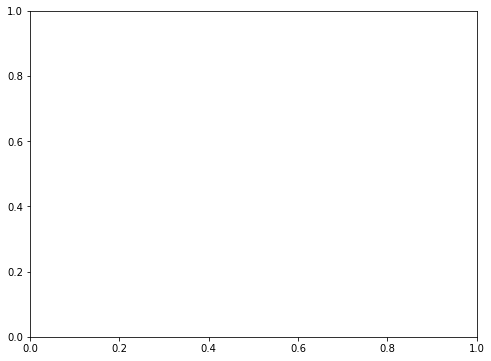

In [51]:
# get one color per artist
colors = get_colors('Dark2', n)

fig, ax = plt.subplots(figsize=[8, 6])
lines = []
for artist, c in zip(top_artists, colors):
    ax = plays[artist].plot(kind='line', linewidth='4', alpha=0.6, marker='o', color=c)
    lines.append(artist)
    
ax.yaxis.grid(True)
ax.set_xticklabels(plays.index.levels[1], rotation=0, rotation_mode='anchor', ha='center')
ax.set_ylabel('Cumulative number of plays', fontproperties=label_font)
ax.set_xlabel('Year', fontproperties=label_font)
ax.set_title('Cumulative number of plays per artist over time', fontproperties=title_font)
ax.legend(lines, loc='upper right', bbox_to_anchor=(1.395,1.017))

plt.savefig('images/lastfm-scrobbles-top-artists-years.png', dpi=96, bbox_inches='tight')
plt.show()

## Characteristics of artists' names

Text analysis of artist name strings

In [52]:
# remove 'The ' and 'A ' preceding artist names, get unique set of names, then get first letter frequency
artists_clean = scrobbles['artist'].str.replace('The ','').str.replace('A ','')
first_letters = pd.Series(artists_clean.unique()).map(lambda x: x.upper()[0]).value_counts()
first_letters = first_letters[[c for c in string.ascii_uppercase]]

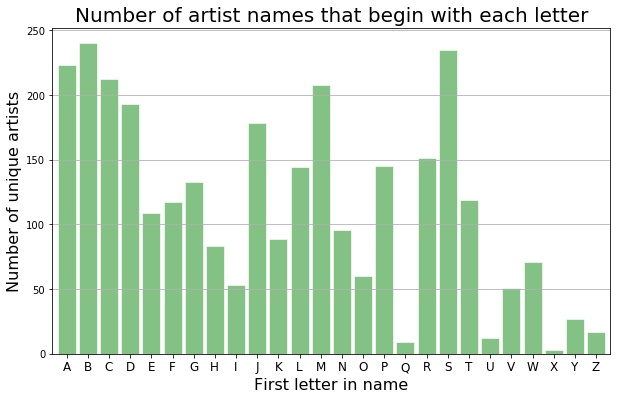

In [53]:
# plot the frequency of artist names that begin with each letter
ax = first_letters.plot(kind='bar', figsize=[10, 6], width=0.85, alpha=0.6, color='#339933', edgecolor='w')
ax.yaxis.grid(True)
ax.set_xticklabels(first_letters.index, rotation=0, rotation_mode='anchor', ha='center', fontproperties=ticks_font)

ax.set_title('Number of artist names that begin with each letter', fontproperties=title_font)
ax.set_xlabel('First letter in name', fontproperties=label_font)
ax.set_ylabel('Number of unique artists', fontproperties=label_font)

plt.savefig('images/lastfm-artists-first-letter-count.png', dpi=96, bbox_inches='tight')
plt.show()

In [54]:
# which artist names begin with the letter 'X'?
str(list(pd.Series(artists_clean[artists_clean.str.upper().str.startswith('X')].unique())))

"['xx', 'Xavier Rudd', 'Xoel López']"

In [55]:
# what are the most common first words in artist names that begin with 'M'?
artists_m = pd.Series(artists_clean[artists_clean.str.upper().str.startswith('M')].unique())
artists_m.map(lambda x: x.split()[0]).value_counts().head(15)

Maria       9
Michael     6
Mr.         4
Max         3
Manuel      3
Mike        3
Midnight    3
Manu        2
Modest      2
Mark        2
MC          2
Music       2
Matt        2
Mano        2
My          2
dtype: int64

In [56]:
# what are the most common first words in all the artist names?
pd.Series(scrobbles['artist'].unique()).map(lambda x: x.split()[0].lower()).value_counts().head(15)

the        192
john        17
david       14
peter       12
london      11
la          10
james        9
maria        9
black        8
alex         8
new          7
robert       7
richard      7
don          7
charles      6
dtype: int64

In [57]:
# what are the most common words in all the artist names, anywhere in the name?
word_list = []
stop_list = ['&','the','and','of','a','in','for','la','los','el','de']
for artist in artists_clean.unique():
    for word in artist.split():
        word_list.append(word.lower())

word_list = [word for word in word_list if word not in stop_list]
pd.Series(word_list).value_counts().head(15)

orchestra       86
symphony        35
john            21
david           20
music           19
philharmonic    19
london          18
y               14
new             14
peter           13
james           13
radio           13
van             12
black           12
national        11
dtype: int64

In [58]:
# what is the longest artist name?
print('"{}"'.format(max(artists_clean, key=len)))

"Maria Callas/Nicolai Gedda/Andréa Guiot/Robert Massard/Nadine Sautereau/Jane Berbié/Jean-Paul Vauquelin/Jacques Pruvost/Maurice Maievski/Claude Calès/Jacques Mars/Choeurs René Duclos/Choeurs d'Enfants Jean Pesneaud/Choeurs et Orchestre de l"


In [59]:
# what is the distribution of lengths of artist names (up to n number of characters)?
n = 50
name_lengths = pd.Series([len(artist) for artist in artists_clean.unique()])
name_lengths = name_lengths.value_counts().sort_index()
name_lengths = name_lengths.iloc[0:n+1].reindex(range(n+1), fill_value=0)

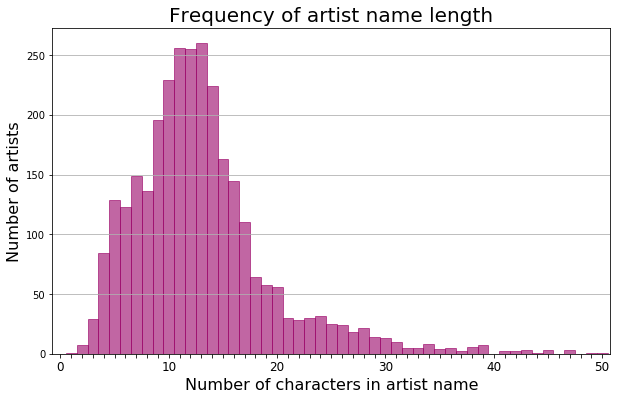

In [60]:
ax = name_lengths.plot(kind='bar', figsize=(10,6), alpha=0.6, width=1, color='#990066', edgecolor='#990066')

xlabels = [x if x % 10 == 0 else '' for x in name_lengths.index]
ax.set_xticklabels(xlabels, rotation=0, rotation_mode='anchor', ha='center', fontproperties=ticks_font)
ax.yaxis.grid(True)

ax.set_title('Frequency of artist name length', fontproperties=title_font)
ax.set_xlabel('Number of characters in artist name', fontproperties=label_font)
ax.set_ylabel('Number of artists', fontproperties=label_font)

plt.savefig('images/lastfm-artists-name-length.png', dpi=96, bbox_inches='tight')
plt.show()